https://mc-stan.org/users/documentation/case-studies/radon.html

In [151]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_context('notebook')
import cmdstanpy as stan
import arviz as az

First, we import the data from a local file, and extract Minnesota's data.

In [2]:
# Import radon data
srrs2 = pd.read_csv('data/srrs2.dat')

In [3]:
srrs2.head()

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,stoptm,startdt,stopdt,activity,pcterr,adjwt,dupflag,zipflag,cntyfips,county
0,1,AZ,AZ,4,85920,1,1,1,2,N,...,1100,112987,120287,0.3,0.0,136.060971,0,0,1,APACHE
1,2,AZ,AZ,4,85920,1,0,9,0,,...,700,70788,71188,0.6,33.3,128.784975,0,0,1,APACHE
2,3,AZ,AZ,4,85924,1,1,1,3,N,...,1145,70788,70788,0.5,0.0,150.245112,0,0,1,APACHE
3,4,AZ,AZ,4,85925,1,1,1,3,N,...,1900,52088,52288,0.6,97.2,136.060971,0,0,1,APACHE
4,5,AZ,AZ,4,85932,1,1,1,1,N,...,900,70788,70788,0.3,0.0,136.060971,0,0,1,APACHE


In [4]:
srrs2.columns = srrs2.columns.map(str.strip)
srrs_mn = srrs2.assign(fips=srrs2.stfips*1000 + srrs2.cntyfips)[srrs2.state=='MN']

Next, obtain the county-level predictor, uranium, by combining two variables.

In [6]:
cty = pd.read_csv('data/cty.dat')
cty_mn = cty[cty.st=='MN'].copy()
cty_mn[ 'fips'] = 1000*cty_mn.stfips + cty_mn.ctfips

Use the merge method to combine home- and county-level information in a single DataFrame

In [7]:
srrs_mn = srrs_mn.merge(cty_mn[['fips', 'Uppm']], on='fips')
srrs_mn = srrs_mn.drop_duplicates(subset='idnum')
u = np.log(srrs_mn.Uppm)

n = len(srrs_mn)

In [8]:
srrs_mn.head()


,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,stopdt,activity,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm
0,5081,MN,MN,27,55735,5,1,1,3,N,...,12288,2.2,9.7,1146.499190,1,0,1,AITKIN,27001,0.502054
1,5082,MN,MN,27,55748,5,1,0,4,Y,...,12088,2.2,14.5,471.366223,0,0,1,AITKIN,27001,0.502054
2,5083,MN,MN,27,55748,5,1,0,4,Y,...,21188,2.9,9.6,433.316718,0,0,1,AITKIN,27001,0.502054
3,5084,MN,MN,27,56469,5,1,0,4,Y,...,123187,1.0,24.3,461.623670,0,0,1,AITKIN,27001,0.502054
4,5085,MN,MN,27,55011,3,1,0,4,Y,...,13088,3.1,13.8,433.316718,0,0,3,ANOKA,27003,0.428565


We also need a lookup table (dict) for each unique county, for indexing.

In [9]:
srrs_mn.county = srrs_mn.county.str.strip()
mn_counties = srrs_mn.county.unique()
counties = len(mn_counties)

In [10]:
counties

85

Finally, create local copies of variables.

In [11]:
county_lookup = dict(zip(mn_counties, range(len(mn_counties))))
county = srrs_mn['county_code'] = srrs_mn.county.replace(county_lookup).values
radon = srrs_mn.activity
srrs_mn['log_radon'] = log_radon = np.log(radon + 0.1).values
floor_measure = srrs_mn.floor.values

Distribution of radon levels in MN (natural scale):

<AxesSubplot:>

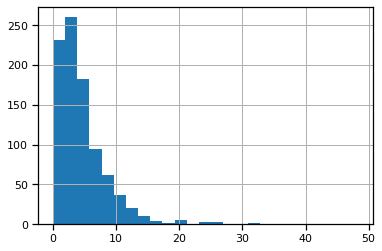

In [13]:
srrs_mn.activity.hist(bins=25)

<AxesSubplot:>

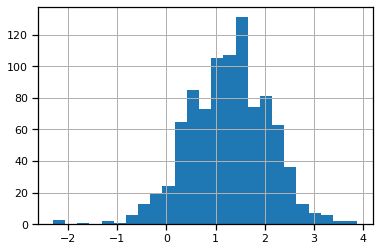

In [12]:
srrs_mn.activity.apply(lambda x: np.log(x+0.1)).hist(bins=25)

Conventional approaches
The two conventional alternatives to modeling radon exposure represent the two extremes of the bias-variance tradeoff:
Complete pooling:
Treat all counties the same, and estimate a single radon level.
yi=α+βxi+ϵi
 
No pooling:
Model radon in each county independently.
yi=αj[i]+βxi+ϵi
 
where  j=1,…,85
 
The errors  ϵi
  may represent measurement error, temporal within-house variation, or variation among houses.
To specify this model in Stan, we begin by constructing the data block, which includes vectors of log-radon measurements (y) and floor measurement covariates (x), as well as the number of samples (N).

## Model with Stan
First bring in and compile your model

In [47]:
sm = stan.CmdStanModel(stan_file='models/radon_pooled.stan')

INFO:cmdstanpy:compiling stan program, exe file: /Users/steve/code/stan/stanspace/dkr/workbench/models/radon_pooled
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/steve/code/stan/stanspace/dkr/workbench/models/radon_pooled


## Complete pooling

In [17]:
print(sm.code())

data {
    int<lower=0> N;
    vector[N] x;
    vector[N] y;
}

parameters {
    vector[2] beta;
    real<lower=0> sigma;
}

model {
    y ~ normal(beta[1] + beta[2] * x, sigma);
}


In [18]:
dt = {
    'N': len(log_radon),
    'x': floor_measure,
    'y': log_radon
}

In [28]:
pd.Series(dt['x']).describe()

count    919.000000
mean       0.166485
std        0.372719
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
dtype: float64

In [29]:
pd.Series(dt['y']).describe()

count    919.000000
mean       1.264779
std        0.819355
min       -2.302585
25%        0.693147
50%        1.308333
75%        1.808289
max        3.877432
dtype: float64

In [31]:
sm_fit = sm.sample(
    data=dt, 
    output_dir = 'output',
    chains=2,
    iter_warmup=1000,
    iter_sampling=1000
)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2


I'm assuming here that I should throw away the warm-up samples so I start the index at `[1000:]`

In [38]:
sm_posterior = sm_fit.draws_pd(["beta"])[1000:]

In [39]:
sm_posterior

,beta[1],beta[2]
1000,1.29098,-0.506325
1001,1.35910,-0.489985
1002,1.34290,-0.537095
1003,1.36895,-0.686560
1004,1.38569,-0.573129
...,...,...
1995,1.38279,-0.623607
1996,1.39208,-0.645572
1997,1.34911,-0.549161
1998,1.38039,-0.624395


The sample can be extracted for plotting and summarization.

In [40]:
b0, m0 = sm_posterior.T.mean(1)

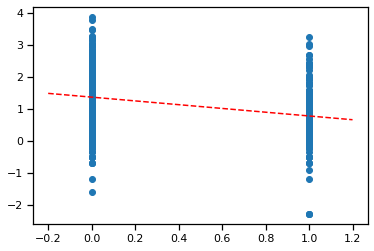

In [44]:
plt.scatter(srrs_mn.floor, np.log(srrs_mn.activity+0.1))
xvals = np.linspace(-0.2, 1.2)
plt.plot(xvals, b0 + m0*xvals, 'r--')

So the model above does complete pooling (i.e. ignores all the within county correlation) and just estimates two means (one for each floor)

Complete pooling:

Treat all counties the same, and estimate a single radon level.

`yi=α+βxi+ϵi`
 


## Fixed effects

In [176]:
unpooled_data = {'N': len(log_radon),
               'county': county+1, # Stan counts starting at 1
               'x': floor_measure,
               'y': log_radon}


In [177]:
sm_fixed = stan.CmdStanModel(stan_file='models/radon_fixed.stan')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/steve/code/stan/stanspace/dkr/workbench/models/radon_fixed


In [178]:
print(sm_fixed.code())

// fixed effects approach
// separate mean for each county
data {
  int<lower=0> N; 
  int<lower=1,upper=85> county[N];
  vector[N] x;
  vector[N] y;
} 
parameters {
  vector[85] a;
  real beta;
  real<lower=0,upper=100> sigma;
} 
transformed parameters {
  vector[N] y_hat;

  for (i in 1:N)
    y_hat[i] <- beta * x[i] + a[county[i]];
}
model {
  y ~ normal(y_hat, sigma);
}


In [179]:
sm_fixed_fit = sm_fixed.sample(
    data=unpooled_data, 
    output_dir = 'output',
    chains=2,
    iter_warmup=1000,
    iter_sampling=1000
)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2


In [199]:
sm_fixed_posterior_a = sm_fixed_fit.draws_pd(["a"])[1000:]
sm_fixed_posterior_a.head()

,a[1],a[2],a[3],a[4],a[5],a[6],a[7],a[8],a[9],a[10],...,a[76],a[77],a[78],a[79],a[80],a[81],a[82],a[83],a[84],a[85]
1000,0.428724,0.868878,2.11532,1.46000,1.37931,1.35226,2.02063,2.10238,0.797209,1.18427,...,1.99383,1.40650,1.53206,0.805658,1.37991,1.87827,2.21093,1.89047,1.62477,0.829111
1001,1.047240,1.079210,1.18376,2.08208,1.26307,1.62585,2.36256,2.27698,1.327030,1.87877,...,2.12185,1.77536,1.11825,-0.007875,1.38492,2.15267,2.31853,1.24316,1.87148,0.189064
1002,0.946077,0.873374,1.60439,1.64610,1.39462,1.80938,1.99228,2.02941,1.006400,1.13335,...,1.40477,1.59374,1.27309,0.195319,1.30675,3.00001,1.09937,1.70151,1.93195,1.016910
1003,0.998932,0.963757,1.40545,1.51091,1.28083,1.31696,1.96558,1.97383,1.100730,1.86226,...,2.58829,2.06161,1.39920,0.843042,1.42070,2.14883,2.80279,1.56006,1.47751,1.411490
1004,1.158770,1.035140,1.78880,1.53851,1.65077,1.18351,1.89453,2.32298,1.032230,1.83757,...,2.64035,1.96069,1.64211,0.782498,1.40896,2.18960,2.69185,1.64699,1.59011,1.707140


In [192]:
unpooled_estimates = pd.Series(sm_fixed_posterior_a.mean(0).values, index=mn_counties)

In [193]:
unpooled_se = pd.Series(sm_fixed_posterior_a.std(0).values, index=mn_counties)

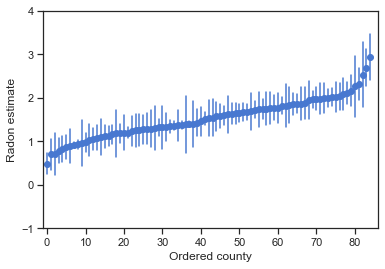

In [194]:
order = unpooled_estimates.sort_values().index

plt.scatter(range(len(unpooled_estimates)), unpooled_estimates[order])
for i, m, se in zip(range(len(unpooled_estimates)), unpooled_estimates[order], unpooled_se[order]):
    plt.plot([i,i], [m-se, m+se], 'b-')
plt.xlim(-1,86); plt.ylim(-1,4)
plt.ylabel('Radon estimate');plt.xlabel('Ordered county');


Here are visual comparisons between the pooled and unpooled estimates for a subset of counties representing a range of sample sizes.

In [195]:
sm_fixed_fit.draws_pd(["beta"])[1000:]

,beta
1000,-0.695172
1001,-0.670754
1002,-0.741997
1003,-0.581957
1004,-0.632423
...,...
1995,-0.666950
1996,-0.690007
1997,-0.734275
1998,-0.683836


In [196]:
sm_fixed_posterior_beta = sm_fixed_fit.draws_pd(["beta"])[1000:]
m = sm_fixed_posterior_beta.mean(0)[0] # extract index 0 to convert to scalar
print(m)

-0.686358184


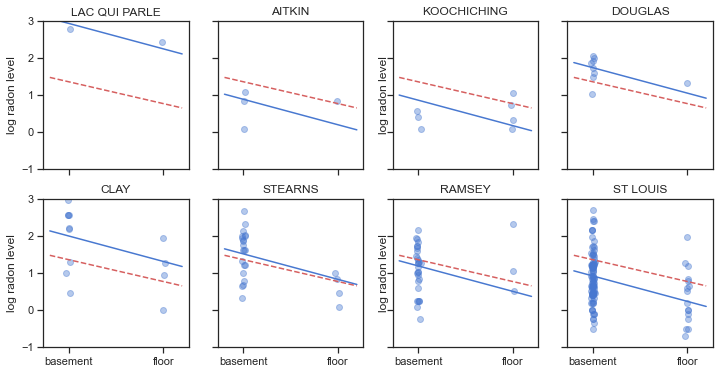

In [197]:
sample_counties = ('LAC QUI PARLE', 'AITKIN', 'KOOCHICHING', 
                    'DOUGLAS', 'CLAY', 'STEARNS', 'RAMSEY', 'ST LOUIS')

fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()
for i,c in enumerate(sample_counties):
    y = srrs_mn.log_radon[srrs_mn.county==c]
    x = srrs_mn.floor[srrs_mn.county==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)
    
    # No pooling model
    b = unpooled_estimates[c]
    
    # Plot both models and data
    xvals = np.linspace(-0.2, 1.2)
    axes[i].plot(xvals, m*xvals+b)
    axes[i].plot(xvals, m0*xvals+b0, 'r--')
    axes[i].set_xticks([0,1])
    axes[i].set_xticklabels(['basement', 'floor'])
    axes[i].set_ylim(-1, 3)
    axes[i].set_title(c)
    if not i%2:
        axes[i].set_ylabel('log radon level')

Neither of these models are satisfactory:
if we are trying to identify high-radon counties, pooling is useless
we do not trust extreme unpooled estimates produced by models using few observations

When we pool our data, we imply that they are sampled from the same model. This ignores any variation among sampling units (other than sampling variance):
pooled
When we analyze data unpooled, we imply that they are sampled independently from separate models. At the opposite extreme from the pooled case, this approach claims that differences between sampling units are to large to combine them:
unpooled
In a hierarchical model, parameters are viewed as a sample from a population distribution of parameters. Thus, we view them as being neither entirely different or exactly the same. This is parital pooling.
hierarchical
We can use PyStan to easily specify multilevel models, and fit them using Hamiltonian Monte Carlo.

## Partial pooling model
The simplest partial pooling model for the household radon dataset is one which simply estimates radon levels, without any predictors at any level. A partial pooling model represents a compromise between the pooled and unpooled extremes, approximately a weighted average (based on sample size) of the unpooled county estimates and the pooled estimates.

`α̂ ≈(nj/σ2y)y¯j+(1/σ2α)y¯(nj/σ2y)+(1/σ2α)`
 


- Estimates for counties with smaller sample sizes will shrink towards the state-wide average.
- Estimates for counties with larger sample sizes will be closer to the unpooled county estimates.

In [129]:
sm_pp = stan.CmdStanModel(stan_file='models/radon_pp.stan')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/steve/code/stan/stanspace/dkr/workbench/models/radon_pp


In [97]:
partial_pool_data = {'N': len(log_radon),
               'county': county+1, # Stan counts starting at 1
               'y': log_radon}

In [130]:
sm_pp_fit = sm_pp.sample(
    data=partial_pool_data, 
    output_dir = 'output',
    chains=2,
    iter_warmup=1000,
    iter_sampling=1000
)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2


In [131]:
sm_pp_posterior_a = sm_pp_fit.draws_pd(["a"])[1000:]
sm_pp_posterior_a.head()

,a[1],a[2],a[3],a[4],a[5],a[6],a[7],a[8],a[9],a[10],...,a[76],a[77],a[78],a[79],a[80],a[81],a[82],a[83],a[84],a[85]
1000,0.839417,0.922726,1.15230,1.189540,1.069410,1.527800,1.82603,1.48888,1.313640,1.24358,...,1.57221,1.52183,1.03162,1.148310,1.28111,1.353440,1.61429,1.48104,1.39498,1.36200
1001,1.392830,0.922793,1.23146,1.307910,1.403910,1.468540,1.66378,1.45875,1.012130,1.53504,...,1.34052,1.70568,1.12531,1.086100,1.32408,1.602490,1.32180,1.46401,1.57463,1.19696
1002,0.719161,1.025730,1.37312,1.235050,1.440230,1.337730,1.66302,1.42226,1.331420,1.09470,...,1.52606,1.19066,1.43762,1.103780,1.23806,1.523750,1.43227,1.35800,1.46488,1.35457
1003,0.872514,0.842682,1.34746,0.868292,1.483370,1.767500,1.62274,1.42860,1.285080,1.24936,...,1.15650,1.14529,1.32413,1.173090,1.21699,1.730540,1.40439,1.30161,1.49699,1.22318
1004,0.867527,0.853011,1.03517,1.426350,0.781817,0.867291,1.76204,1.62236,0.954577,1.27307,...,1.38416,2.06846,1.27245,0.864188,1.22541,0.960129,1.52729,1.50896,1.57274,1.44294


In [134]:
sm_pp_posterior_a.mean()

a[1]     1.102172
a[2]     0.944573
a[3]     1.283132
a[4]     1.273954
a[5]     1.328776
           ...   
a[81]    1.640416
a[82]    1.473268
a[83]    1.448181
a[84]    1.526548
a[85]    1.332848
Length: 85, dtype: float64

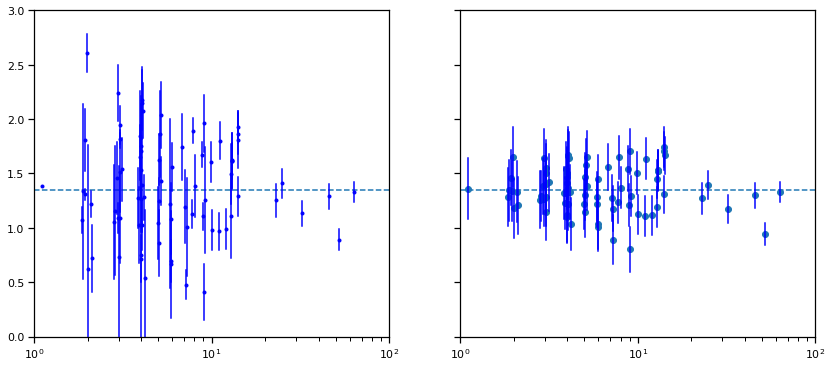

In [138]:
fig, axes = plt.subplots(1, 2, figsize=(14,6), sharex=True, sharey=True)

samples, counties = sm_pp_posterior_a.shape

jitter = np.random.normal(scale=0.1, size=counties)

n_county = srrs_mn.groupby('county')['idnum'].count()
unpooled_means = srrs_mn.groupby('county')['log_radon'].mean()
unpooled_sd = srrs_mn.groupby('county')['log_radon'].std()
unpooled = pd.DataFrame({'n':n_county, 'm':unpooled_means, 'sd':unpooled_sd})
unpooled['se'] = unpooled.sd/np.sqrt(unpooled.n)

axes[0].plot(unpooled.n + jitter, unpooled.m, 'b.')

for j, row in zip(jitter, unpooled.iterrows()):
    name, dat = row
    axes[0].plot([dat.n+j,dat.n+j], [dat.m-dat.se, dat.m+dat.se], 'b-')
axes[0].set_xscale('log')
axes[0].hlines(sm_pp_posterior_a.mean().mean(), 0.9, 100, linestyles='--')

means = sm_pp_posterior_a.mean(axis=0)
sd = sm_pp_posterior_a.std(axis=0)

axes[1].scatter(n_county.values + jitter, means)
axes[1].set_xscale('log')
axes[1].set_xlim(1,100)
axes[1].set_ylim(0, 3)
axes[1].hlines(sm_pp_posterior_a.mean().mean(), 0.9, 100, linestyles='--')

for j,n,m,s in zip(jitter, n_county.values, means, sd):
    axes[1].plot([n+j]*2, [m-s, m+s], 'b-')


## Varying intercept model

This model allows intercepts to vary across county, according to a random effect.

`yi=αj[i]+βxi+ϵi`
 
where

`ϵi∼N(0,σ2y)`
 
and the intercept random effect:

`αj[i]∼N(μα,σ2α)`
 
As with the the “no-pooling” model, we set a separate intercept for each county, but rather than fitting separate least squares regression models for each county, multilevel modeling shares strength among counties, allowing for more reasonable inference in counties with little data.

In [145]:
sm_vi = stan.CmdStanModel(stan_file='models/radon_varying_intercept.stan')

INFO:cmdstanpy:compiling stan program, exe file: /Users/steve/code/stan/stanspace/dkr/workbench/models/radon_varying_intercept
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/steve/code/stan/stanspace/dkr/workbench/models/radon_varying_intercept


In [146]:
varying_intercept_data = {'N': len(log_radon),
                          'J': len(n_county),
                          'county': county+1, # Stan counts starting at 1
                          'x': floor_measure,
                          'y': log_radon}

In [147]:
sm_vi_fit = sm_vi.sample(
    data=varying_intercept_data, 
    output_dir = 'output',
    chains=2,
    iter_warmup=1000,
    iter_sampling=1000
)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1


In [148]:
# Pystan version
# a_sample = pd.DataFrame(varying_intercept_fit['a'])

sm_vi_posterior_a = sm_vi_fit.draws_pd(["a"])[1000:]
sm_vi_posterior_a.head()


,a[1],a[2],a[3],a[4],a[5],a[6],a[7],a[8],a[9],a[10],...,a[76],a[77],a[78],a[79],a[80],a[81],a[82],a[83],a[84],a[85]
1000,1.657880,0.964382,1.96392,1.88730,1.40521,1.15356,1.82595,1.60609,0.94150,1.61384,...,1.79725,1.51457,1.56310,1.382190,1.37518,1.69162,1.54932,1.64366,1.83503,1.25760
1001,0.796043,0.926881,1.02660,1.40363,1.83057,1.66636,1.89893,1.54110,1.44853,1.74870,...,1.60903,1.60862,1.18629,0.634844,1.45100,2.14399,1.59426,1.73298,1.41794,1.80521
1002,1.079290,1.021830,1.10607,1.23892,1.42920,1.49042,2.09470,1.80234,1.24377,1.55532,...,1.50998,1.58914,1.26280,1.164870,1.36994,1.79273,1.72122,1.79508,1.93588,1.42558
1003,1.481940,0.980469,1.96450,1.86368,1.59989,1.62713,1.70708,1.68313,1.23925,1.51108,...,1.89505,1.82651,1.61150,1.292800,1.37722,2.07782,1.60617,1.48088,1.38762,1.49681
1004,0.989172,1.009860,1.31881,1.09079,1.25916,1.28593,1.97903,1.66028,1.05288,1.83257,...,1.64950,1.70160,1.01157,1.062520,1.36547,1.76219,1.61687,1.63254,1.96953,1.42630


<AxesSubplot:>

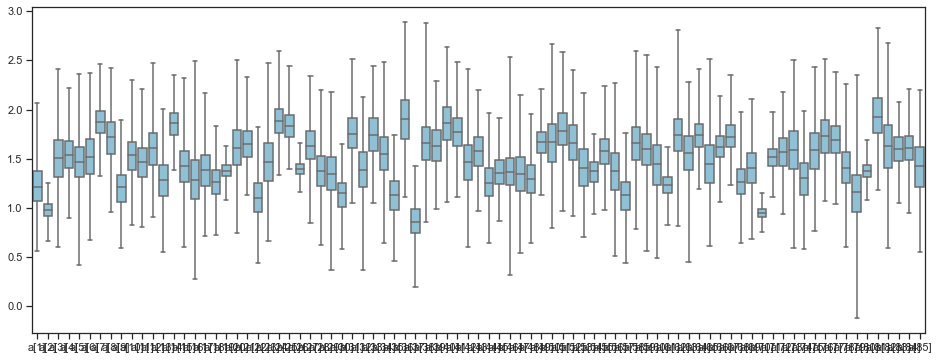

In [149]:
import seaborn as sns
sns.set(style="ticks", palette="muted", color_codes=True)

# Plot the orbital period with horizontal boxes
plt.figure(figsize=(16, 6))
sns.boxplot(data=sm_vi_posterior_a, whis=np.inf, color="c")

In [152]:
samples = az.from_cmdstanpy(posterior=sm_vi_fit)

array([[<AxesSubplot:title={'center':'sigma_a'}>,
        <AxesSubplot:title={'center':'sigma_a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>]], dtype=object)

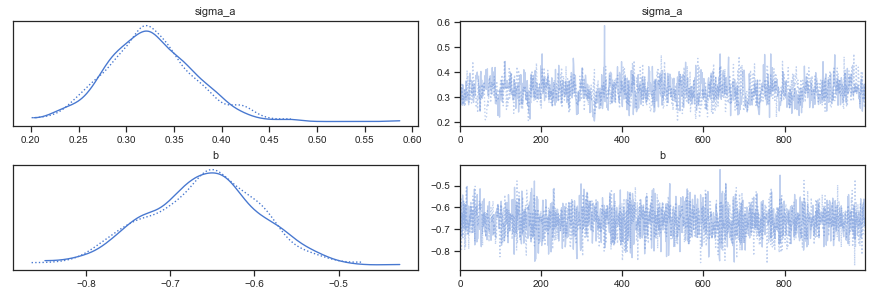

In [156]:
az.plot_trace(samples, var_names=['sigma_a', 'b'])

The estimate for the floor coefficient is approximately -0.66, which can be interpreted as houses without basements having about half ( exp(−0.66)=0.52
 ) the radon levels of those with basements, after accounting for county.

In [162]:
sm_vi_posterior_b = sm_vi_fit.draws_pd(["b"])[1000:]
sm_vi_posterior_b.head()
sm_vi_posterior_b.mean()


b   -0.661374
dtype: float64

In [172]:
xvals = np.arange(2)

bp = sm_vi_fit.draws_pd(["a"])[1000:].mean(axis=0)
# note extract value with index 0 at end of line below
mp = sm_vi_fit.draws_pd(["b"])[1000:].mean()[0]

for bi in bp:
    plt.plot(xvals, mp*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1,1.1);

It is easy to show that the partial pooling model provides more objectively reasonable estimates than either the pooled or unpooled models, at least for counties with small sample sizes.

In [202]:
sm_fixed_fit.draws_pd(["a"])[1000:]

,a[1],a[2],a[3],a[4],a[5],a[6],a[7],a[8],a[9],a[10],...,a[76],a[77],a[78],a[79],a[80],a[81],a[82],a[83],a[84],a[85]
1000,0.428724,0.868878,2.115320,1.46000,1.37931,1.35226,2.02063,2.10238,0.797209,1.184270,...,1.99383,1.40650,1.532060,0.805658,1.37991,1.87827,2.21093,1.89047,1.62477,0.829111
1001,1.047240,1.079210,1.183760,2.08208,1.26307,1.62585,2.36256,2.27698,1.327030,1.878770,...,2.12185,1.77536,1.118250,-0.007875,1.38492,2.15267,2.31853,1.24316,1.87148,0.189064
1002,0.946077,0.873374,1.604390,1.64610,1.39462,1.80938,1.99228,2.02941,1.006400,1.133350,...,1.40477,1.59374,1.273090,0.195319,1.30675,3.00001,1.09937,1.70151,1.93195,1.016910
1003,0.998932,0.963757,1.405450,1.51091,1.28083,1.31696,1.96558,1.97383,1.100730,1.862260,...,2.58829,2.06161,1.399200,0.843042,1.42070,2.14883,2.80279,1.56006,1.47751,1.411490
1004,1.158770,1.035140,1.788800,1.53851,1.65077,1.18351,1.89453,2.32298,1.032230,1.837570,...,2.64035,1.96069,1.642110,0.782498,1.40896,2.18960,2.69185,1.64699,1.59011,1.707140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1.508960,0.997334,2.089480,1.22268,1.30300,1.41852,1.82898,1.68382,1.146630,1.727210,...,1.97970,1.79960,1.395570,0.438461,1.21216,2.10156,1.96645,1.24865,1.31920,0.988459
1996,1.050170,0.958935,2.131410,1.32374,1.31149,1.44735,1.64484,1.51311,1.179920,2.060690,...,2.13477,1.70340,1.016210,0.752775,1.25292,2.39632,2.54035,1.32659,1.34343,0.978638
1997,1.164250,0.874677,0.961786,1.82773,1.83528,1.14441,2.30284,2.32083,1.040540,0.958906,...,2.04954,1.86094,1.824660,0.643921,1.43506,2.73500,1.68575,1.89963,2.06260,1.626570
1998,1.397230,0.903395,0.963575,1.98884,1.48460,1.64808,2.50824,2.28359,0.943530,0.983263,...,1.90776,1.73378,1.903370,0.941654,1.44334,2.26589,1.87046,1.61575,1.63679,1.629830


In [209]:
sm_fixed_fit.draws_pd(["beta"])[1000:].mean()

beta   -0.686358
dtype: float64

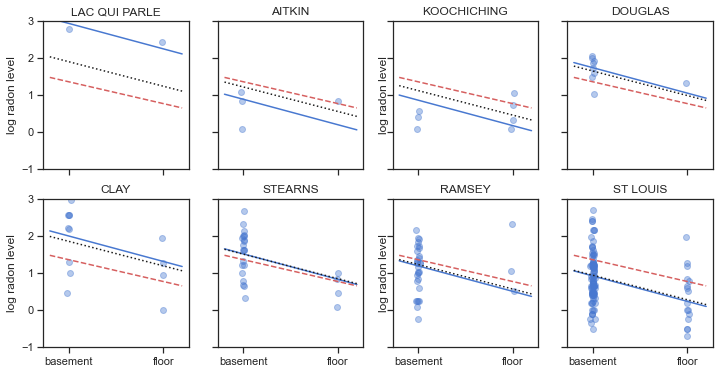

In [211]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()
for i,c in enumerate(sample_counties):
    
    # Plot county data
    y = srrs_mn.log_radon[srrs_mn.county==c]
    x = srrs_mn.floor[srrs_mn.county==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)
    
    # No pooling model
    # m,b = unpooled_estimates[['floor', c]]
    # TODO: not sure this is correct translation of the line above
    m = sm_fixed_fit.draws_pd(["beta"])[1000:].mean()[0]
    b = unpooled_estimates[c]
    
    xvals = np.linspace(-0.2, 1.2)
    # Unpooled estimate
    axes[i].plot(xvals, m*xvals+b)
    # Pooled estimate
    axes[i].plot(xvals, m0*xvals+b0, 'r--')
    # Partial pooling esimate
    axes[i].plot(xvals, mp*xvals+bp[county_lookup[c]], 'k:')
    axes[i].set_xticks([0,1])
    axes[i].set_xticklabels(['basement', 'floor'])
    axes[i].set_ylim(-1, 3)
    axes[i].set_title(c)
    if not i%2:
        axes[i].set_ylabel('log radon level')

## Varying slope model

Alternatively, we can posit a model that allows the counties to vary according to how the location of measurement (basement or floor) influences the radon reading.

`yi=α+βj[i]xi+ϵi`
 


In [213]:
varying_slope_data = {'N': len(log_radon),
                          'J': len(n_county),
                          'county': county+1, # Stan counts starting at 1
                          'x': floor_measure,
                          'y': log_radon}

In [214]:
sm_vs = stan.CmdStanModel(stan_file='models/radon_vs.stan')

INFO:cmdstanpy:compiling stan program, exe file: /Users/steve/code/stan/stanspace/dkr/workbench/models/radon_vs
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/steve/code/stan/stanspace/dkr/workbench/models/radon_vs


In [215]:
sm_vs_fit = sm_vs.sample(
    data=varying_slope_data, 
    output_dir = 'output',
    chains=2,
    iter_warmup=1000,
    iter_sampling=1000
)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2


In [218]:
sm_vs_posterior_b = sm_vs_fit.draws_pd(["b"])[1000:]
sm_vs_posterior_b.head()

,b[1],b[2],b[3],b[4],b[5],b[6],b[7],b[8],b[9],b[10],...,b[76],b[77],b[78],b[79],b[80],b[81],b[82],b[83],b[84],b[85]
1000,-0.580397,-0.619925,-0.423991,-0.456305,-0.366163,-0.308434,-0.189324,-0.617005,-0.624859,-0.619752,...,-0.679857,-0.896141,-0.533759,-0.349698,-0.789150,-0.081215,-1.005610,-0.682562,-0.604639,-0.502676
1001,-0.625842,-1.118440,-0.523791,-0.789861,-0.496938,-0.957370,-0.461491,-0.031241,-0.425503,-0.789586,...,-0.549666,-0.463183,-0.618085,-0.884388,-0.739536,-0.873480,-0.655829,-1.076250,-0.666485,-0.723972
1002,-0.562709,-0.504809,-0.868057,-0.772507,-0.665562,-0.437483,-0.249767,-0.415684,-0.191782,-0.990527,...,-0.583709,-0.725737,-0.740720,-0.669540,-0.817759,0.009152,-0.356840,-0.703063,-0.687515,-0.619569
1003,-0.631575,-1.153920,-0.463825,-0.465625,-0.467142,-0.786120,-0.501833,-0.677957,-0.848684,-0.057434,...,-0.623095,-0.597026,-0.768023,-0.687375,-0.651035,-0.823695,-0.967328,-0.866496,-0.512107,-0.600453
1004,-0.027276,-0.561493,-0.623297,-0.679653,-0.665897,-0.197283,0.333022,-0.021156,0.033498,-0.914560,...,-0.333447,-0.594340,-0.871815,-0.719543,-0.943430,0.423637,-0.113620,-0.611063,-0.619386,-0.481957


<AxesSubplot:>

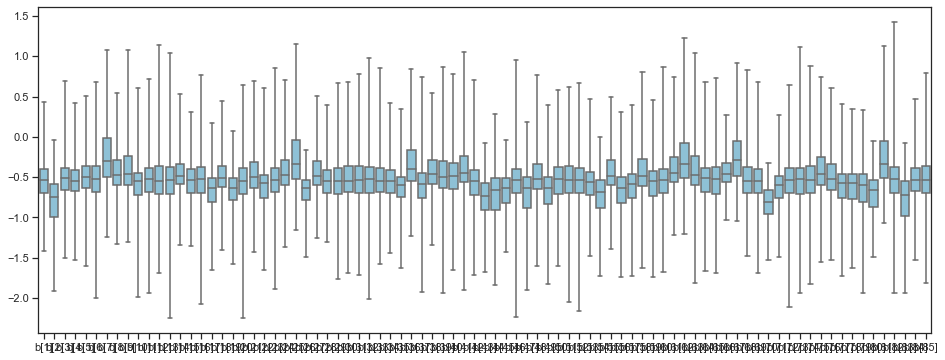

In [219]:
# Plot the slope estimates
plt.figure(figsize=(16, 6))
sns.boxplot(data=sm_vs_posterior_b, whis=np.inf, color="c")

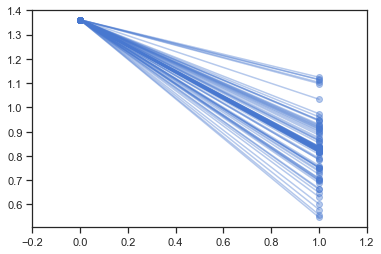

In [220]:
xvals = np.arange(2)
b = sm_vs_fit.draws_pd(["a"])[1000:].mean()[0]
m = sm_vs_fit.draws_pd(["b"])[1000:].mean(axis=0)
for mi in m:
    plt.plot(xvals, mi*xvals + b, 'bo-', alpha=0.4)
plt.xlim(-0.2, 1.2);